#Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
%matplotlib inline

Use future imports for python 3.0 forward compatibility

In [2]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

Other imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

# set size of inline plots
matplotlib.rcParams['figure.figsize'] = [14, 10]

Some global data

In [4]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 100000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Fetch symbol data from internet

In [5]:
ts = pf.fetch_timeseries(symbol)

In [6]:
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [7]:
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)

In [8]:
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


Add technical indicator: 50 day ma, and 200 day ma

In [9]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

In [10]:
ts.tail()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2019-05-09,2875.97,2836.40,2859.84,2870.72,3638820000,2870.72,2860.03,2775.74
2019-05-10,2891.31,2825.39,2863.10,2881.40,3529600000,2881.40,2861.97,2776.04
2019-05-13,2840.19,2801.43,2840.19,2811.87,3894030000,2811.87,2862.13,2775.87
2019-05-14,2852.54,2820.12,2820.12,2834.41,3322720000,2834.41,2862.96,2775.85
2019-05-15,2858.68,2815.08,2820.38,2850.96,3125950000,2850.96,2864.19,2776.01


Plot closing price along with moving averages

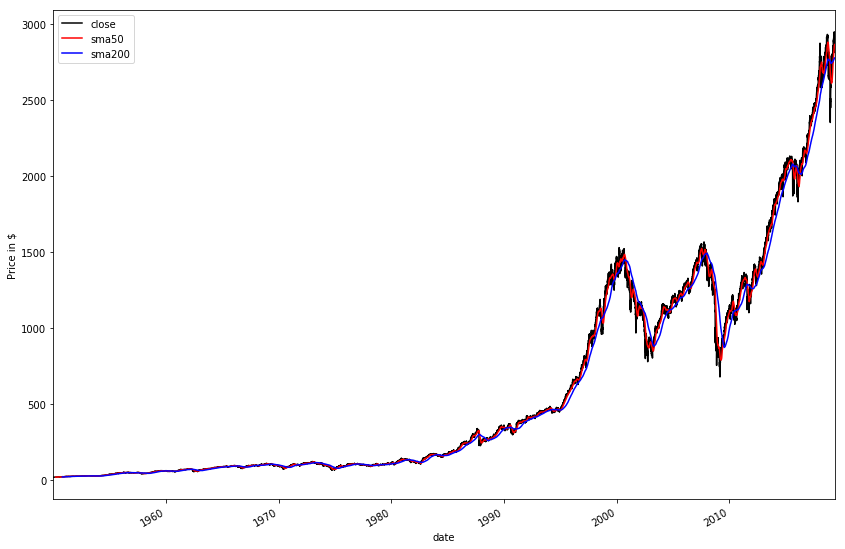

In [11]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [12]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [13]:
cash = capital
shares = 0
start_flag = True
end_flag = False

import time
t0 = time.time()


for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]
    end_flag = True if (i == len(ts.index) - 1) else False

    if pd.isnull(sma200) or ts.index[i] < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = ts.index[i]
        end = ts.index[-1]

    # buy
    if tlog.num_open_trades() == 0:
        if sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1] and not end_flag:

            # calculate shares to buy and remaining cash
            shares, cash = tlog.calc_shares(cash, close)

            # enter buy in trade log
            tlog.enter_trade(date, close, shares)
            print("{0} BUY  {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.OPEN)
        else:
            # hold
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)

    # sell
    elif (sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1]) or end_flag:

            # enter sell in trade log
            idx = tlog.exit_trade(date, close)
            shares = tlog.get_log()['qty'][idx]
            print("{0} SELL {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.CLOSE)   
            
            # update cash
            cash = tlog.calc_cash(cash, close, shares)
            
            # update shares
            shares = 0

    # hold
    else:
        dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)    

t1 = time.time()
total = t1-t0
print(total)
        

1953-12-21 00:00:00 BUY  4008 ^GSPC @ 24.95
1956-10-26 00:00:00 SELL 4008 ^GSPC @ 46.27
1957-06-03 00:00:00 BUY  3914 ^GSPC @ 47.37
1957-09-26 00:00:00 SELL 3914 ^GSPC @ 42.57
1958-05-08 00:00:00 BUY  3788 ^GSPC @ 43.99
1959-10-30 00:00:00 SELL 3788 ^GSPC @ 57.52
1959-12-30 00:00:00 BUY  3645 ^GSPC @ 59.77
1960-02-15 00:00:00 SELL 3645 ^GSPC @ 55.17
1961-01-04 00:00:00 BUY  3446 ^GSPC @ 58.36
1962-05-07 00:00:00 SELL 3446 ^GSPC @ 66.02
1963-01-03 00:00:00 BUY  3571 ^GSPC @ 63.72
1965-07-22 00:00:00 SELL 3571 ^GSPC @ 83.85
1965-09-17 00:00:00 BUY  3325 ^GSPC @ 90.05
1966-04-28 00:00:00 SELL 3325 ^GSPC @ 91.13
1967-02-03 00:00:00 BUY  3468 ^GSPC @ 87.36
1968-02-27 00:00:00 SELL 3468 ^GSPC @ 90.53
1968-05-17 00:00:00 BUY  3240 ^GSPC @ 96.90
1969-03-13 00:00:00 SELL 3240 ^GSPC @ 98.39
1969-05-27 00:00:00 BUY  3078 ^GSPC @ 103.57
1969-06-23 00:00:00 SELL 3078 ^GSPC @ 96.23
1970-10-22 00:00:00 BUY  3552 ^GSPC @ 83.38
1971-09-24 00:00:00 SELL 3552 ^GSPC @ 98.15
1972-01-26 00:00:00 BUY  3402 ^

Retrieve log DataFrames

In [14]:
tlog = tlog.get_log()

In [15]:
tlog.tail(100)

,entry_date,entry_price,long_short,qty,exit_date,exit_price,pl_points,pl_cash,cumul_total
0,1953-12-21,24.95,long,4008,1956-10-26 00:00:00,46.27,21.32,85450.56,85450.56
1,1957-06-03,47.37,long,3914,1957-09-26 00:00:00,42.57,-4.80,-18787.20,66663.36
2,1958-05-08,43.99,long,3788,1959-10-30 00:00:00,57.52,13.53,51251.64,117915.00
3,1959-12-30,59.77,long,3645,1960-02-15 00:00:00,55.17,-4.60,-16767.01,101147.99
4,1961-01-04,58.36,long,3446,1962-05-07 00:00:00,66.02,7.66,26396.35,127544.34
5,1963-01-03,63.72,long,3571,1965-07-22 00:00:00,83.85,20.13,71884.22,199428.56
6,1965-09-17,90.05,long,3325,1966-04-28 00:00:00,91.13,1.08,3590.98,203019.54
7,1967-02-03,87.36,long,3468,1968-02-27 00:00:00,90.53,3.17,10993.55,214013.09
8,1968-05-17,96.90,long,3240,1969-03-13 00:00:00,98.39,1.49,4827.59,218840.68
9,1969-05-27,103.57,long,3078,1969-06-23 00:00:00,96.23,-7.34,-22592.51,196248.17


In [16]:
dbal = dbal.get_log()

In [17]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2019-05-09,9438148.86,9308319.47,9420923.61,3281,2091.39,1
2019-05-10,9488479.69,9272195.62,9455964.47,3281,2091.39,1
2019-05-13,9320754.58,9193582.99,9227837.24,3281,2091.39,1
2019-05-14,9361275.25,9254905.49,9301790.31,3281,2091.39,1
2019-05-15,9381420.24,9238369.12,9356091.02,3281,2091.39,2


Generate strategy stats - display all available stats

In [18]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                   1950-10-18
end                                                     2019-05-15
beginning_balance                                           100000
ending_balance                                          9356091.02
total_net_profit                                        9256091.02
gross_profit                                            9898464.11
gross_loss                                              -642373.09
profit_factor                                                15.41
return_on_initial_capital                                  9256.09
annual_return_rate                                            6.84
trading_period                           68 years 6 months 27 days
pct_time_in_market                                           67.20
total_num_trades                                                35
num_winning_trades                                              26
num_losing_trades                                             

Run Benchmark

In [19]:
benchmark = pf.Benchmark(symbol, capital, start, end)
benchmark.run()

1950-10-18 00:00:00 BUY  4997 ^GSPC @ 20.01
2019-05-15 00:00:00 SELL 4997 ^GSPC @ 2850.96


Retrieve benchmark logs

In [20]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [21]:
benchmark.stats = benchmark.stats()
pf.print_full(benchmark.stats)

start                                                   1950-10-18
end                                                     2019-05-15
beginning_balance                                           100000
ending_balance                                         14246256.95
total_net_profit                                       14146256.95
gross_profit                                           14146256.95
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                 14146.26
annual_return_rate                                            7.50
trading_period                           68 years 6 months 27 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
num_winning_trades                                               1
num_losing_trades                                             

Plot Equity Curves: Strategy vs Benchmark

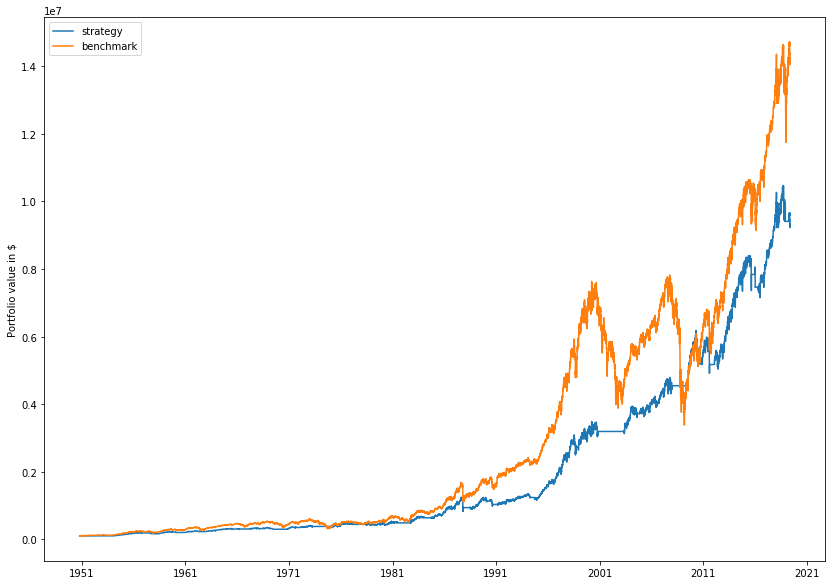

In [22]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

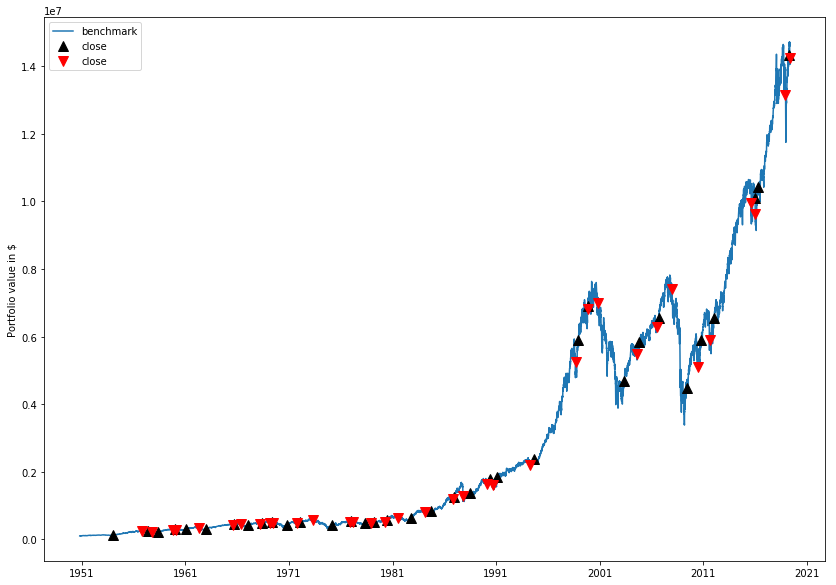

In [23]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.84,7.50
max_closed_out_drawdown,-33.23,-56.78
drawdown_annualized_return,-4.86,-7.57
drawdown_recovery,-0.15,-1.42
best_month,14.94,23.49
worst_month,-29.56,-29.56
sharpe_ratio,0.66,0.55
sortino_ratio,0.68,0.71
monthly_std,2.94,4.14


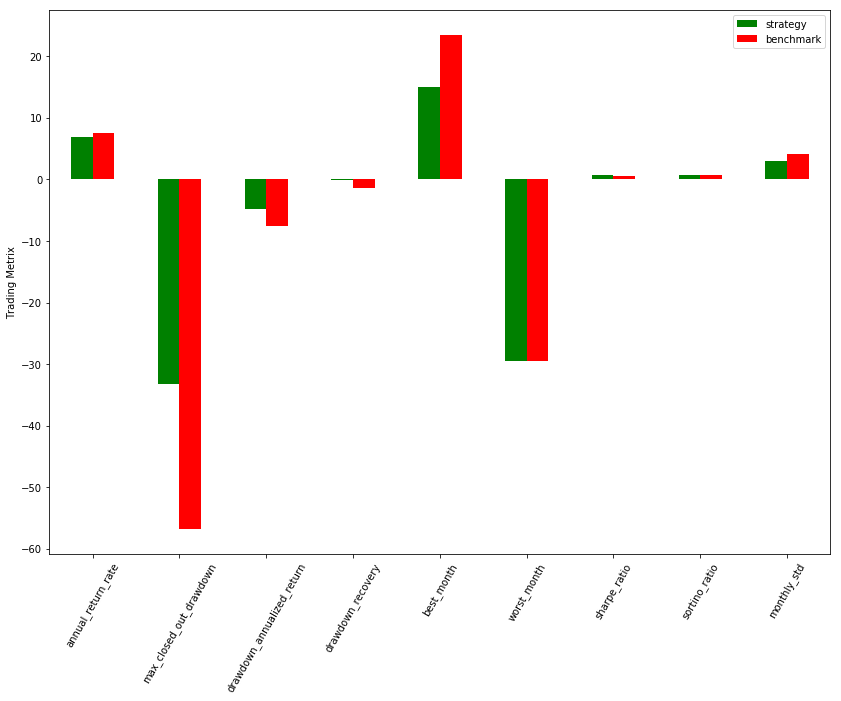

In [24]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df